<a href="https://colab.research.google.com/github/AdminMas7er/JBG040-DC1-Group-14/blob/main/new_test_file_with_some_trials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Introduction:
In this template, methods are provided to get you started on the task at hand (please see project description). Please implement your solution in the code cells marked with **TODO**. Most of the other code cells are hidden, feel free to explore and change these. These cells implement a basic pipeline for training your model but you may want to explore more complex procedures. **Make sure you run all cells before trying to implement your own solution!**



#Imports and definitions:

In [ ]:
#@title
import numpy as np
import requests
import io
from torch.utils.data import TensorDataset
import matplotlib.pyplot as plt
import torch
from scipy.ndimage import rotate
%matplotlib inline
from torch.utils.data import Dataset
import random
import torch
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from tqdm import tqdm

class BatchSampler():
  """
  Implements an iterable which given a torch dataset and a batch_size
  will produce batches of data of that given size. The batches are
  returned as tuples in the form (images, labels).
  Can produce balanced batches, where each batch will have an equal 
  amount of samples from each class in the dataset. If your dataset is heavily
  imbalanced, this might mean throwing away a lot of samples from 
  over-represented classes!
  """

  def __init__(self, batch_size, dataset, balanced=False):
    self.batch_size = batch_size
    self.dataset = dataset
    self.balanced = balanced
    if self.balanced:
      # Counting the ocurrence of the class labels:
      unique, counts = np.unique(self.dataset.targets, return_counts=True) 
      indexes = []
      # Sampling an equal amount from each class:
      for i in range(len(unique)):
        indexes.append(np.random.choice(np.where(self.dataset.targets == i)[0], size=counts.min(), replace=False))
      # Setting the indexes we will sample from later:
      self.indexes = np.concatenate(indexes)
    else:
      # Setting the indexes we will sample from later (all indexes):
      self.indexes = [i for i in range(len(dataset))]


  def __len__(self):
    return (len(self.indexes) // self.batch_size) + 1
  
  def shuffle(self):
    # We do not need to shuffle if we use the balanced sampling method.
    # Shuffling is already done when making the balanced samples.
    if not self.balanced:
      random.shuffle(self.indexes)
    
  def __iter__(self):
    remaining = False
    self.shuffle()
    # Go over the datset in steps of 'self.batch_size':
    for i in range(0, len(self.indexes), self.batch_size):
        imgs, labels = [], []
        # If our current batch is larger than the remaining data, we quit:
        if i + self.batch_size > len(self.indexes):
          remaining = True
          break
        # If not, we yield a complete batch:
        else:
          # Getting a list of samples from the dataset, given the indexes we defined:
          X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, i + self.batch_size)]
          Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, i + self.batch_size)]
          # Stacking all the samples and returning the target labels as a tensor:
          yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()
    # If there is still data left that was not a full batch:
    if remaining:
      # Return the last batch (smaller than batch_size):
      X_batch = [self.dataset[self.indexes[k]][0] for k in range(i, len(self.indexes))]
      Y_batch = [self.dataset[self.indexes[k]][1] for k in range(i, len(self.indexes))]
      yield torch.stack(X_batch).float(), torch.tensor(Y_batch).long()

class ImageDataset(Dataset):
  """
  Creates a DataSet from numpy arrays while keeping the data 
  in the more efficient numpy arrays for as long as possible and only
  converting to torchtensors when needed (torch tensors are the objects used
  to pass the data through the neural network and apply weights).
  """
  
  def __init__(self, x, y, transform=None, target_transform=None):
    self.targets = y
    self.imgs = x
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.targets)

  def __getitem__(self, idx):
    image = torch.from_numpy(self.imgs[idx] / 255).float()
    label = self.targets[idx]
    return image, label

def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 


class_labels = {0: 'Atelectasis',
                1: 'Effusion',
                2: 'Infiltration',
                3: 'No Finding',
                4: 'Nodule',
                5: 'Pneumothorax'}

# Downloading the data:
> **Changed: the datasets are limited in size. This should work moderately fast**

The following cells will download the pre-processed X-ray images with their accompanying labels.

The download (400 MB) may take a while.

In [ ]:
#@title
# Downloading the labels of each image:
train_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/i6MvQ8nqoiQ9Tci/download')
test_y = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/wLXiOjVAW4AWlXY/download')

In [ ]:
#@title
# Downloading the images:
train_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4rwSf9SYO1ydGtK/download')
test_x = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/dvY2LpvFo6dHef0/download')

## Build the datasets

In [ ]:
#@title
train_dataset = ImageDataset(train_x, train_y)
test_dataset = ImageDataset(test_x, test_y)

unique_labels = set(class_labels.keys())

# Augmentation

## Methods

In [ ]:
def translate(img, label, shift=10, direction='right', roll=True):
    assert direction in ['right', 'left', 'down', 'up'], 'Directions should be top|up|left|right'
    img = img.copy()
    if direction == 'right':
        right_slice = img[:,:, -shift:].copy()
        img[:,:, shift:] = img[:,:, :-shift]
        if roll:
            img[:,:,:shift] = 0
    if direction == 'left':
        left_slice = img[:,:, :shift].copy()
        img[:,:, :-shift] = img[:,:, shift:]
        if roll:
            img[:,:, -shift:] = 0
    if direction == 'down':
        down_slice = img[:,-shift:, :].copy()
        img[:,shift:, :] = img[:,:-shift,:]
        if roll:
            img[:,:shift, :] = 0
    if direction == 'up':
        upper_slice = img[:,:shift, :].copy()
        img[:,:-shift, :] = img[:,shift:, :]
        if roll:
            img[:,-shift:,:] = 0
    return img, label

def translate_right(img, label, shift=10, roll = True):
  img = img.copy()
  right_slice = img[:,:, -shift:].copy()
  img[:,:, shift:] = img[:,:, :-shift]
  if roll:
    img[:,:,:shift] = 0
  return img, label

def translate_left(img, label, shift=10, roll = True):
  img = img.copy()
  right_slice = img[:,:, shift:].copy()
  img[:,:, -shift:] = img[:,:, :shift]
  if roll:
    img[:,:,:-shift] = 0
  return img, label

def translate_down(img, label, shift=10, roll=True):
  down_slice = img[:,-shift:, :].copy()
  img[:,shift:, :] = img[:,:-shift,:]
  if roll:
      img[:,:shift, :] = 0
  return img, label

def crop_image_top_right(img, label, crop_size = 10):
    assert crop_size <= img.shape[1], "Crop size should be less than image size"
    img = img.copy()
    w,h = img.shape[1:]
    return img, label

def zoom_image(img, label, zoom_factor = 2):
    h, w = img.shape[1:]
    h_new, w_new = h/zoom_factor, w/zoom_factor
    begin_h = int(round((h/2)-(h_new/2)))
    img = img[:, begin_h:h-begin_h, begin_h:h-begin_h]
    return img, label

def rotate_image(img, label, angle = 15):
    img = rotate(input = img, angle = angle, axes = (1,2), reshape = False)

    return img, label

def gaussian_noise_image(train_image, train_label, noise):
    new_image = train_image + noise
    
    return new_image, train_label

## application

In [ ]:
import math
import random

def augment_datasets(train_x, train_y):
  i = 0

  unique, counts = np.unique(train_y, return_counts=True) 
  images_to_go = dict(zip(unique, 6500 - counts))
  images_per_class = dict(zip(unique, counts))
  augmentations_per_img = dict(zip(unique, [math.ceil(6500 / i) for i in counts]))

  while sum(images_to_go.values()) > 0:
    i += 1

    if images_to_go[ train_y[i] ] != 0:

      augmentations_to_go = augmentations_per_img[ train_y[i]]

      methods = [0, 1, 2, 3, 4, 5, 6, 7, 8]
      new_imgs = []
      new_labels = []
      
      while augmentations_to_go > 0 and images_to_go[ train_y[i] ] > 0:
        
        augmentations_to_go -= 1
        images_to_go[ train_y[i] ] -= 1
        method = methods.pop( random.randrange( len(methods) ))
        
        if method == 0:
          image, label = translate( train_x[i], train_y[i], direction='right' )

        elif method == 1:
          image, label = translate( train_x[i], train_y[i], direction='down' )

        elif method == 3:
          image, label = translate( train_x[i], train_y[i], direction='left', )

        elif method == 2:
          image, label = rotate_image( train_x[i], train_y[i] )

        else:
          noise = np.random.binomial(0, 1, size = train_x[i].shape) * 10
          image, label = gaussian_noise_image( train_x[i], train_y[i], noise )
        
        new_labels.append(label)
        new_imgs.append(image)
      
      train_x = np.append(train_x, new_imgs, axis=0)
      train_y = np.append(train_y, new_labels, axis=0)

  return train_x, train_y

In [ ]:
# it can be nice to note down the starting time to get an idea of how long it takes haha :)
train_x, train_y = augment_datasets(train_x, train_y)
# started 10.10 ended 11.25
# max i is 13272



## Build new dataset

In [ ]:
#@title
train_dataset = ImageDataset(train_x, train_y)
test_dataset = ImageDataset(test_x, test_y)

unique_labels = set(class_labels.keys())

# Plotting the data:

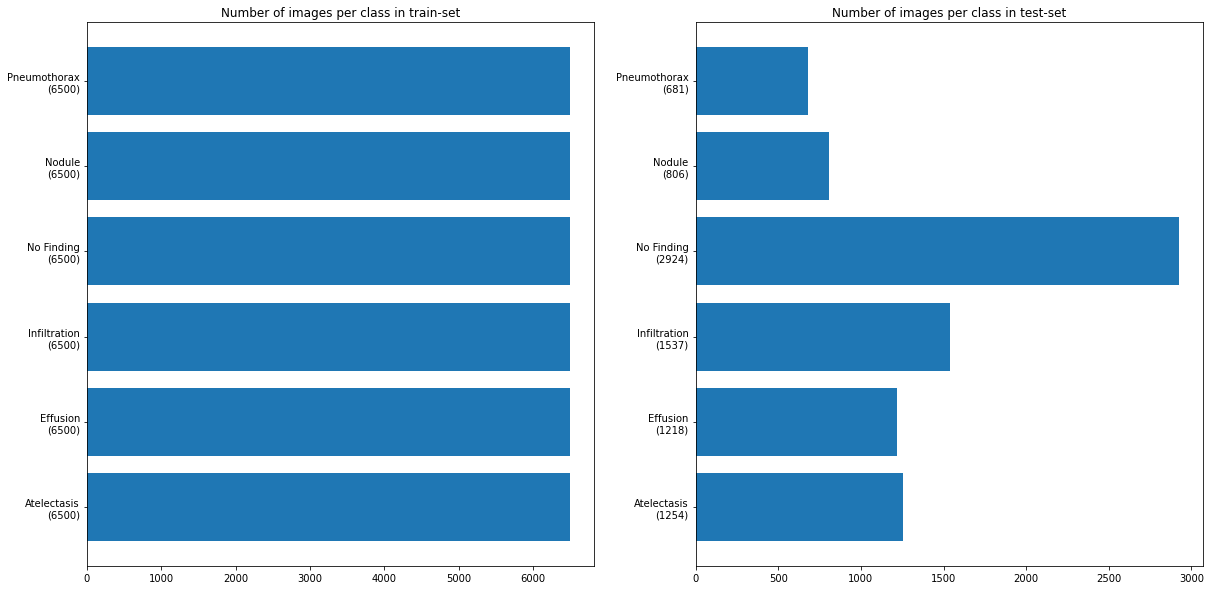

In [ ]:
#@title
# Plotting the label distribution in train/test set:
fig, ax = plt.subplots(ncols=2, figsize=[20,10])

unique, counts = np.unique(train_y, return_counts=True) 
ax[0].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[0].set_title('Number of images per class in train-set')

unique, counts = np.unique(test_y, return_counts=True) 
ax[1].barh([class_labels[i] + f'\n({c})' for i, c in zip(unique, counts)], counts)
ax[1].set_title('Number of images per class in test-set');

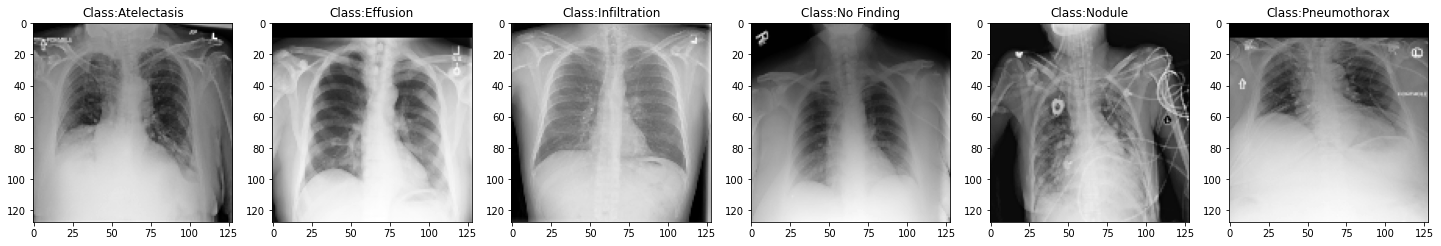

In [ ]:
#@title
# Plotting some images
fig, ax = plt.subplots(ncols=len(unique_labels), figsize=[25,5])

for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  ax[k].imshow(train_x[ind].reshape(128,128), cmap='gray')
  ax[k].set_title(f'Class:{class_labels[train_y[ind]]}')

# Defining the neural network and relevant methods:


In [ ]:
from torch.nn.modules.batchnorm import BatchNorm1d
class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            
            # Defining a 2D convolution layer
            nn.Conv2d(1, 64, kernel_size=4, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=4),

            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3),

            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(144, 256),
            nn.Linear(256, n_classes),
            nn.BatchNorm1d(6),
            nn.Softmax(dim=1) 
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

# Make sure your model instance is assigned to a variable 'model':
model = Net(n_classes = 6)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.015)
loss_function = nn.CrossEntropyLoss()
# loss_function = nn.CrossEntropyLoss(torch.cuda.FloatTensor([2, 2, 0.5, 1.2, 1.2, 1.2]))

##Move model to cuda:

In [ ]:
DEBUG = False
device = 'cuda' if ( torch.cuda.is_available and not DEBUG) else 'cpu'
# model.to(device)
model.to(device)
print(str(model))

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1))
    (9): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=144, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=6, bias=True)
    (2): BatchNorm1d(6, eps=1

##Defining our training/testing methods:

In [ ]:
#@title
def train_model(model, train_sampler, optimizer, loss_function):
  # Lets keep track of all the losses:
  losses = []
  # Put the model in train mode:
  model.train()
  # Feed all the batches one by one:
  for batch in tqdm(train_sampler):
    # Get a batch:
    x, y = batch
    # Making sure our samples are stored on the same device as our model: 
    x = x.to(device)
    y = y.to(device)
    # Get predictions:
    predictions = model.forward(x)
    loss = loss_function(predictions, y)
    losses.append(loss)
    # We first need to make sure we reset our optimizer at the start.
    # We want to learn from each batch seperately, 
    # not from the entire dataset at once.
    optimizer.zero_grad()
    # We now backpropagate our loss through our model:
    loss.backward()
    # We then make the optimizer take a step in the right direction.
    optimizer.step()
  return losses

def test_model(model, test_sampler, loss_function):
  # Setting the model to evaluation mode:
  model.eval()
  losses = []
  # We need to make sure we do not update our model based on the test data:
  with torch.no_grad():
    for (x, y) in tqdm(test_sampler):
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x)
      loss = loss_function(prediction, y)
      losses.append(loss)
  return losses

#Training our model:

100%|█████████▉| 3900/3901 [01:22<00:00, 47.46it/s]



Epoch 1 training done, loss on train set: 1.796943187713623



100%|██████████| 85/85 [00:04<00:00, 19.14it/s]



Epoch 1 testing done, loss on test set: 1.7960907220840454



100%|█████████▉| 3900/3901 [01:19<00:00, 48.90it/s]



Epoch 2 training done, loss on train set: 1.796689510345459



100%|██████████| 85/85 [00:04<00:00, 19.13it/s]



Epoch 2 testing done, loss on test set: 1.8009295463562012



100%|█████████▉| 3900/3901 [01:19<00:00, 48.91it/s]



Epoch 3 training done, loss on train set: 1.7966784238815308



100%|██████████| 85/85 [00:04<00:00, 19.14it/s]



Epoch 3 testing done, loss on test set: 1.7967709302902222



100%|█████████▉| 3900/3901 [01:19<00:00, 48.92it/s]



Epoch 4 training done, loss on train set: 1.7964131832122803



100%|██████████| 85/85 [00:04<00:00, 19.12it/s]



Epoch 4 testing done, loss on test set: 1.799147367477417



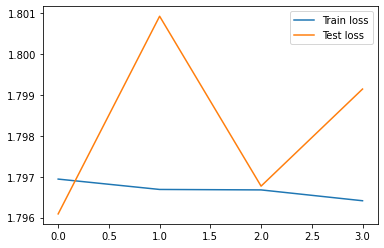

In [ ]:
#@title
# Lets now train and test our model for multiple epochs:
model = Net(n_classes = 6)
model.to(device)

n_epochs = 13 #change value to 1 for debugging reasons
batch_size = 16

train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

mean_losses_train = []
mean_losses_test = []
for e in range(n_epochs):
  # Training:
  #pdb.set_trace(context=1000)

  losses = train_model(model, train_sampler, optimizer, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_train.append(mean_loss)
  print(f'\nEpoch {e + 1} training done, loss on train set: {mean_loss}\n')

  # Testing:
  losses = test_model(model, test_sampler, loss_function)
  # Calculating and printing statistics:
  mean_loss = sum(losses) / len(losses)
  mean_losses_test.append(mean_loss)
  print(f'\nEpoch {e + 1} testing done, loss on test set: {mean_loss}\n')

  if (e > 2):
    if (abs( mean_losses_train[-1] - mean_losses_train[-2] ) < 0.001):
      break

# Plotting the historic loss:
fig, ax = plt.subplots()
ax.plot(mean_losses_train, label='Train loss')
ax.plot(mean_losses_test, label='Test loss')
ax.legend()
plt.show()

#Evaluation our model:
**TODO** write your own methods to evaluate the model. For example, calculate the accuracy of the model on the test-set:

## Accuracy

In [ ]:
model.eval()
# We need to make sure we do not update our model based on the test data:
def calculate_accuracy():
  with torch.no_grad():
    correct = 0
    count = 0
    for (x, y) in test_sampler:
      # Making sure our samples are stored on the same device as our model:
      x = x.to(device)
      y = y.to(device)
      prediction = model.forward(x).argmax(axis=1)
      correct += sum(prediction == y)
      count += len(y)
  accuracy = (correct/count).detach().cpu().numpy()
  return float(accuracy)

calculate_accuracy()

0.17054632306098938

## Saliency map
https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e

https://towardsdatascience.com/saliency-map-using-pytorch-68270fe45e80

https://ravivaishnav20.medium.com/visualizing-feature-maps-using-pytorch-12a48cd1e573 Feature map

Check the model used in the example

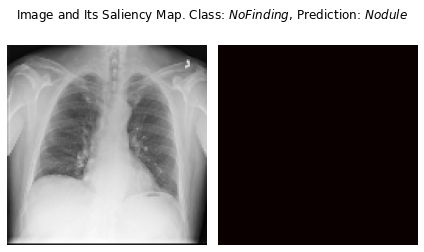

In [ ]:
from torchvision import models, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

i = 5             # add the index of the picture you want to analyze 

image = train_x[i]      # get the image to map, this must be a np.ndarray
img = image               # safe to use as the reference picture of the scan
image.resize([1, 1, 128, 128])
image = torch.from_numpy(image).float()


image = image.to(device)
image.requires_grad_()    # catch the gradient during the backpropagation

output = model(image)     # run the picture through the model
output_idx = output.argmax()
output_max = output[0, output_idx]
output_max.backward()

prediction = class_labels[ (torch.argmax(output, 1)[0]).item() ]

saliency, _ = torch.max(image.grad.data.abs(), dim=1)
saliency = saliency.reshape(128, 128)
image = image.reshape(-1, 128, 128)

# draw the image and its saliency map

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img.reshape(128, 128), cmap='gray')
ax[0].axis('off')
ax[1].imshow(saliency.cpu(), cmap='hot')
ax[1].axis('off')
plt.tight_layout()
fig.suptitle(f'Image and Its Saliency Map. Class: $\it{class_labels[train_y[i]]}$, Prediction: $\it{prediction}$ ')
plt.show()

## Confusion matrix


In [ ]:
for k, label in enumerate(unique_labels):
  ind = list(train_y).index(label)
  print(f'{class_labels[train_y[ind]]}, {label}')

Atelectasis, 0
Effusion, 1
Infiltration, 2
No Finding, 3
Nodule, 4
Pneumothorax, 5


In [ ]:
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd

# iterate over the batches, and concatenate the output predictions
@torch.no_grad()	# we want this functions execution to omit gradient tracking
def get_Y_pred(model, test_set, n):
    model.eval()
    y_preds = torch.tensor([]).cuda()

    with torch.no_grad():
      loader = DataLoader(test_set, batch_size = 500)

    for batch in loader:
        images, labels = batch
        images, labels = images.cuda(), labels.cuda()
        preds = model(images)
        y_preds = torch.cat( (y_preds, preds) , dim=0)

    return y_preds.argmax(dim=1).cpu()
    
def get_matrix():
  y_preds = get_Y_pred(model, test_dataset, 100)
  matrix = confusion_matrix(test_dataset.targets, y_preds)
  return matrix


get_matrix()

array([[191, 275, 374, 123,  97, 194],
       [192, 245, 291, 104, 116, 270],
       [276, 227, 369, 231, 160, 274],
       [511, 540, 733, 381, 272, 487],
       [136, 164, 218, 105,  80, 103],
       [159, 127, 119,  78,  92, 106]])

## Recall, Precision, F1 score


In [ ]:
def one_hot_encode(labels):
    encoded_labels = []
    for k in range(len(labels)):
        encoded_labels.append([1 if labels[k] == i else 0 for i in range(6)])
    return torch.tensor(encoded_labels).to(device)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def calculate_stats():
  # (H) needed y_pred defined inside the function get_matrix():
  y_preds = get_Y_pred(model, test_dataset, 100)
  
  y_true = test_dataset.targets

  Precision = precision_score(y_true, y_preds, average=None)
  Recall = recall_score(y_true, y_preds, average=None)
  F1 = f1_score(y_true, y_preds, average=None)

  y_true_encoded = one_hot_encode(y_true)
  y_preds_encoded = one_hot_encode(y_preds)
  roc_auc = roc_auc_score(y_true_encoded.cpu(), y_preds_encoded.cpu(), multi_class='ovr', average=None) # one vs rest

  scores = pd.DataFrame( { "Recall" : Recall, "Precision" : Precision , "F1" : F1, 'roc auc' : roc_auc}, 
                        index=["Atelectasis", 'Effusion', 'Infiltration', 'No Finding', 'Nodule', 'Pneumothorax'])

  # https://vitalflux.com/micro-average-macro-average-scoring-metrics-multi-class-classification-python/
  scores.loc['mean (macr0)', 'Recall'] =    recall_score(y_true, y_preds, average='macro')
  scores.loc['mean (macr0)', 'Precision'] = precision_score(y_true, y_preds, average='macro')
  scores.loc['mean (macr0)', 'F1'] =        f1_score(y_true, y_preds, average='macro')
  scores.loc['mean (macr0)', 'roc auc'] =   roc_auc_score(y_true_encoded.cpu(), y_preds_encoded.cpu(), multi_class='ovr', average='macro')

  return scores

calculate_stats()

,Recall,Precision,F1,roc auc
Atelectasis,0.152313,0.130375,0.140493,0.487264
Effusion,0.201149,0.155260,0.175250,0.508031
Infiltration,0.240078,0.175380,0.202692,0.494004
No Finding,0.130301,0.372798,0.193107,0.506835
Nodule,0.099256,0.097919,0.098583,0.501230
Pneumothorax,0.155653,0.073919,0.100236,0.492028
mean (macr0),0.163125,0.167609,0.151727,0.498232


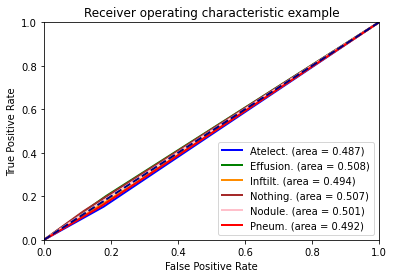

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

# (H) needed y_true_encoded and y_preds_encoded defined inside casculate_stats():
y_true = test_dataset.targets
y_preds = get_Y_pred(model, test_dataset, 100)
y_true_encoded = one_hot_encode(y_true)
y_preds_encoded = one_hot_encode(y_preds) 

for i in range(6):
    fpr[i], tpr[i], _ = roc_curve(y_true_encoded[:, i].cpu(), y_preds_encoded[:, i].cpu())
    roc_auc[i] = np.round( auc(fpr[i], tpr[i]), 3)


plt.figure()
plt.plot(fpr[0], tpr[0], color='blue', lw=2, label= f'Atelect. (area = {roc_auc[0]})')
plt.plot(fpr[1], tpr[1], color='green', lw=2, label= f'Effusion. (area = {roc_auc[1]})')
plt.plot(fpr[2], tpr[2], color="darkorange", lw=2, label= f"Inftilt. (area = {roc_auc[2]})")
plt.plot(fpr[3], tpr[3], color='brown', lw=2, label= f'Nothing. (area = {roc_auc[3]})')
plt.plot(fpr[4], tpr[4], color='pink', lw=2, label= f'Nodule. (area = {roc_auc[4]})')
plt.plot(fpr[5], tpr[5], color='red', lw=2, label= f'Pneum. (area = {roc_auc[5]})')

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show();

## Run all evaluations


In [ ]:
def evaluate():
  model.eval()

  accuracy = calculate_accuracy()
  y_preds = get_Y_pred(model, test_dataset, 100)
  matrix = get_matrix()
  scores = calculate_stats()

  return accuracy, y_preds, matrix, scores

# Add row in df with all data on the run


In [ ]:
def add_to_df():

  # (H) needed are the evaluation metrics defined by evaluate():
  accuracy, y_preds, matrix, scores = evaluate()
  
  models_df.loc[run, 'model + layers'] = str(model)

  models_df.loc[run, 'optimizer'] = str(optimizer)
  models_df.loc[run, 'loss function'] = str(loss_function)

  models_df.loc[run, 'n epochs'] = e
  models_df.loc[run, 'batch size'] = batch_size

  models_df.loc[run, 'accuracy'] = accuracy

  # This could be a useful metric once the different groups have the same size:
  # The code finds the lowest nr of predictions in the columns and adds the nr and the corresponding group(s) to the df 
  avg = np.sum( matrix, axis=0 )
  models_df.loc[run, 'min predictions nr'] = avg.min()
  models_df.loc[run, 'min predictions group'] = str( [class_labels[i] for i in np.where( avg == avg.min() )[0]] )
  models_df.loc[run, 'matrix'] = str( matrix )

  for index, row in scores.iterrows():
    if index != 'mean (macro)':
      models_df.loc[run, [f'{index} Recall', f'{index} Precision', f'{index} F1', f'{index} roc'] ] = row['Recall'], row['Precision'], row['F1'], row['roc auc']
    else:
      models_df.loc[run, [f'{index} Recall etc', f'{index} roc'] ] = row['Recall'], row['roc auc']

In [ ]:
models_df = pd.DataFrame()
run = 0

# !!Add to df

In [ ]:
add_to_df()
run += 1

# to get the overview of the model use: print( models_df['model + layers'][i] )
# this also works for matrix and optimizer

from google.colab import files

models_df.to_csv('Learning rate.csv')
files.download("Learning rate.csv")

models_df

In [ ]:
models_df

# praying for no errors: Four layer model
> **This model contains the code for the four layer model, and the iterative code written to imput different values. Next step is to analyze whether it's possible to analyze the hyperparameters in a less random manner.** <br>
**Probably closest to the model we'll use, so use this one to test loss and optimizer functions**

This part also has the code to download the dataframe

In [ ]:

class Net(nn.Module):   
    def __init__(self, n_classes):
        super(Net, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 128, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(4),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(128, 64, kernel_size=4, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(3),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(64, 32, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(2),
            torch.nn.Dropout(p=0.5, inplace=True),
            # Defining another 2D convolution layer
            nn.Conv2d(32, 16, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            nn.AdaptiveMaxPool2d(1),
            torch.nn.Dropout(p=0.5, inplace=True),
        )

        self.linear_layers = nn.Sequential(
            #nn.Linear(144,2), 
            #nn.ReLU(),
            #nn.Linear(2, 256), 
            #nn.ReLU(),
            nn.Linear(16, n_classes),
            nn.BatchNorm1d(6, eps=1e-5, momentum=0.1, affine=True, track_running_stats=True),
            nn.Softmax(dim=1)
        )

    # Defining the forward pass    
    def forward(self, x):
        x = self.cnn_layers(x)
        # After our convolutional layers which are 2D, we need to flatten our
        # input to be 1 dimensional, as the linear layers require this.
        x = x.view(x.size(0), -1)
        x = self.linear_layers(x)
        return x

In [ ]:
print(str(model))

Net(
  (cnn_layers): Sequential(
    (0): Conv2d(1, 128, kernel_size=(4, 4), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): AdaptiveMaxPool2d(output_size=4)
    (4): Dropout(p=0.5, inplace=True)
    (5): Conv2d(128, 64, kernel_size=(4, 4), stride=(1, 1))
    (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU(inplace=True)
    (8): AdaptiveMaxPool2d(output_size=3)
    (9): Dropout(p=0.5, inplace=True)
    (10): Conv2d(64, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): AdaptiveMaxPool2d(output_size=2)
    (14): Dropout(p=0.5, inplace=True)
    (15): Conv2d(32, 16, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (16): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (17): 

In [ ]:
import random

models_df = pd.DataFrame()
run = 0


for i in range (100):
  model = Net(n_classes=6)
  #learnrate = [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
  #                        0.010, 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018, 0.019,
  #                        0.020, 0.021, 0.022, 0.023, 0.024, 0.025, 0.026, 0.027, 0.028, 0.029,
  #                        0.030, 0.031, 0.032, 0.033, 0.034, 0.035, 0.036, 0.037, 0.038, 0.039,
  #                        0.040, 0.041, 0.042, 0.043, 0.044, 0.045, 0.046, 0.047, 0.048, 0.049,
  #                        0.050, 0.051, 0.052, 0.053, 0.054, 0.055, 0.056, 0.057, 0.058, 0.059,
  #                        0.060, 0.061, 0.062, 0.063, 0.064, 0.065, 0.066, 0.067, 0.068, 0.069,
  #                        0.070, 0.071, 0.072, 0.073, 0.074, 0.075, 0.076, 0.077, 0.078, 0.079,
  #                        0.080, 0.081, 0.082, 0.083, 0.084, 0.085, 0.086, 0.087, 0.088, 0.089,
  #                        0.090, 0.091, 0.092, 0.093, 0.094, 0.095, 0.096, 0.097, 0.098, 0.099, 0.1]
                          
  #learnrate = [0.001, 0.003, 0.005, 0.007, 0.009,
  #             0.011, 0.013, 0.015, 0.017, 0.019,
  #             0.021, 0.023, 0.025, 0.027, 0.029,
  #             0.031, 0.033, 0.035, 0.037, 0.039,
  #             0.041, 0.043, 0.045, 0.047, 0.049,
  #             0.051, 0.053, 0.055, 0.057, 0.059,
  #             0.061, 0.063, 0.065, 0.067, 0.069,
  #             0.071, 0.073, 0.075, 0.077, 0.079,
  #             0.081, 0.083, 0.085, 0.087, 0.089,
  #             0.091, 0.093, 0.095, 0.097, 0.099, 0.1]
  learnrate = [0.001, 0.003, 0.005, 0.007, 0.009,
               0.011, 0.013, 0.015, 0.017, 0.019,
               0.021, 0.023, 0.025, 0.027, 0.029,
               0.031, 0.033, 0.035, 0.037, 0.039]

  optimizer = optim.RAdam(model.parameters(), lr=learnrate[i])
  loss_function = nn.CrossEntropyLoss()

  DEBUG = False

  if torch.cuda.is_available() and not DEBUG:
    device = 'cuda'
    model.to(device)
    # Creating a summary of our model and its layers:

  else:
    device='cpu'
    # Creating a summary of our model and its layers:

  batch_size = 16
  train_sampler = BatchSampler(batch_size=batch_size, dataset=train_dataset, balanced=False)
  test_sampler = BatchSampler(batch_size=100, dataset=test_dataset, balanced=False)

  mean_losses_train = []
  mean_losses_test = []
  accuracies = []

  for e in range(10):
    losses = train_model(model, train_sampler, optimizer, loss_function)
    mean_loss = sum(losses) / len(losses)
    mean_losses_train.append(mean_loss)

    losses = test_model(model, test_sampler, loss_function)
    # Calculating and printing statistics:
    mean_loss = sum(losses) / len(losses)
    mean_losses_test.append(mean_loss)


  add_to_df()
  models_df.loc[run, 'learning rate'] = learnrate[i]
  models_df.loc[run, 'losses train'] = mean_losses_train[-1].item()
  models_df.loc[run, 'losses test'] =  mean_losses_test[-1].item()

  min_pred = models_df.loc[run, 'min predictions nr']
  accuracy = models_df.loc[run, 'accuracy']

  if (min_pred !=0):
    print(f'Model {i} might be useful, the min amount of predictions in a class is {min_pred}, and its accuracy is {accuracy}')
  else:
    print(f'Model {i} is probably not useful, it\'s accuracy is {accuracy}' )

  run +=1

In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
df1 = pd.read_csv('Learning rate.csv')

models_df = pd.concat([df1, models_df], ignore_index=True)

In [ ]:
import pandas as pd
from google.colab import files

df1 = pd.read_csv('Learning rate.csv')
df1

AttributeError: ignored

In [ ]:
#df1 = pd.read_csv('Learning rate.csv')
models_df = pd.concat([df1, models_df], ignore_index=True)

In [ ]:
#from google.colab import files

#models_df.to_csv('Learning rate.csv')
#files.download("Learning rate.csv")

models_df

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,model + layers,optimizer,loss function,n epochs,batch size,accuracy,min predictions nr,min predictions group,matrix,Atelectasis Recall,Atelectasis Precision,Atelectasis F1,Atelectasis roc,Effusion Recall,Effusion Precision,Effusion F1,Effusion roc,Infiltration Recall,Infiltration Precision,Infiltration F1,Infiltration roc,No Finding Recall,No Finding Precision,No Finding F1,No Finding roc,Nodule Recall,Nodule Precision,Nodule F1,Nodule roc,Pneumothorax Recall,Pneumothorax Precision,Pneumothorax F1,Pneumothorax roc,mean (macr0) Recall,mean (macr0) Precision,mean (macr0) F1,mean (macr0) roc,learning rate,losses train,losses test,0 preds
0,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.270680,122.0,['Infiltration'],[[335 113 9 34 107 83]\n [186 217 30 26 ...,0.491924,0.266720,0.345896,0.610720,0.318649,0.277494,0.296651,0.576358,0.063142,0.352459,0.107098,0.519971,0.051395,0.224359,0.083632,0.507930,0.330396,0.247253,0.282841,0.564611,0.368576,0.291860,0.325762,0.594860,0.270680,0.276691,0.240313,0.562408,0.001,1.756617,1.754452,1
1,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.262849,0.0,['No Finding'],[[276 149 19 0 141 96]\n [144 253 55 0 ...,0.405286,0.271386,0.325088,0.593833,0.371512,0.268863,0.311961,0.584728,0.092511,0.282511,0.139381,0.522761,0.000000,0.000000,0.000000,0.500000,0.400881,0.247956,0.306397,0.578855,0.306902,0.259950,0.281481,0.566079,0.262849,0.221778,0.227385,0.557709,0.003,1.755997,1.755964,0
2,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.253793,26.0,['No Finding'],[[274 149 2 1 158 97]\n [163 248 21 2 ...,0.402349,0.252070,0.309955,0.581791,0.364170,0.262156,0.304856,0.579589,0.020558,0.269231,0.038199,0.504699,0.005874,0.153846,0.011315,0.499706,0.395007,0.242780,0.300727,0.574302,0.334802,0.262976,0.294574,0.573568,0.253793,0.240510,0.209938,0.552276,0.005,1.758155,1.754535,1
3,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.261870,59.0,['Infiltration'],[[265 154 2 35 136 89]\n [141 274 14 34 ...,0.389134,0.285560,0.329397,0.597210,0.402349,0.266019,0.320281,0.590162,0.023495,0.271186,0.043243,0.505433,0.152717,0.248804,0.189263,0.530250,0.317181,0.243243,0.275335,0.559912,0.286344,0.255570,0.270083,0.559765,0.261870,0.261731,0.237934,0.557122,0.007,1.754699,1.754528,1
4,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.254038,214.0,['Infiltration'],[[303 134 28 21 73 122]\n [182 214 54 29 ...,0.444934,0.256345,0.325282,0.593392,0.314244,0.274008,0.292750,0.573862,0.064611,0.205607,0.098324,0.507342,0.116006,0.221289,0.152216,0.517181,0.202643,0.261364,0.228288,0.544053,0.381791,0.253906,0.304985,0.578708,0.254038,0.245420,0.233641,0.552423,0.009,1.755511,1.758197,1
5,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.253793,0.0,['Infiltration'],[[254 128 0 21 147 131]\n [171 238 0 11 ...,0.372981,0.250988,0.300059,0.575184,0.349486,0.284010,0.313364,0.586637,0.000000,0.000000,0.000000,0.500000,0.076358,0.240741,0.115942,0.514097,0.286344,0.236364,0.258964,0.550661,0.437592,0.249372,0.317697,0.587078,0.253793,0.210246,0.217671,0.552276,0.011,1.755889,1.753153,0
6,NaN,NaN,NaN,Net(\n (cnn_layers): Sequential(\n (0): Co...,"RAdam (\nParameter Group 0\n betas: (0.9, 0...",CrossEntropyLoss(),9.0,16.0,0.256730,27.0,['Infiltration'],[[251 139 0 36 162 93]\n [150 274 5 60 ...,0.368576,0.267591,0.310068,0.583407,0.402349,0.278455,0.329129,0.596916,0.017621,0.444444,0.033898,0.506608,0.168869,0.215356,0.189300,0.522907,0.289280,0.239078,0.261794,0

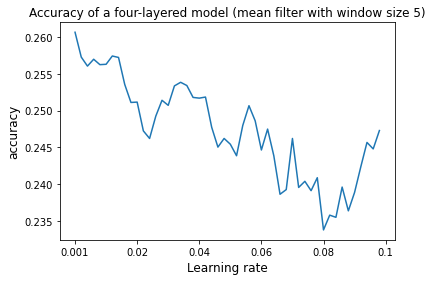

In [ ]:
plt.plot( np.convolve(models_df['accuracy'] / 5, np.ones(5), 'valid') )
plt.xticks([0, 10, 20, 30, 40, 50], [0.001, 0.020, 0.040, 0.060, 0.080, 0.100])
plt.xlabel('Learning rate', size=12)
plt.ylabel('accuracy', size=12)
plt.title('Accuracy of a four-layered model (mean filter with window size 5)');

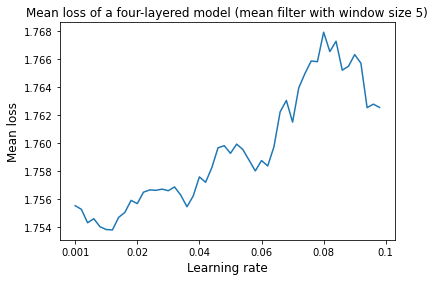

In [ ]:
plt.plot( np.convolve(models_df['losses test'] / 5, np.ones(5), 'valid') )
plt.xticks([0, 10, 20, 30, 40, 50], [0.001, 0.020, 0.040, 0.060, 0.080, 0.100])
plt.xlabel('Learning rate', size = 12)
plt.ylabel('Mean loss', size=12)
plt.title('Mean loss of a four-layered model (mean filter with window size 5)');

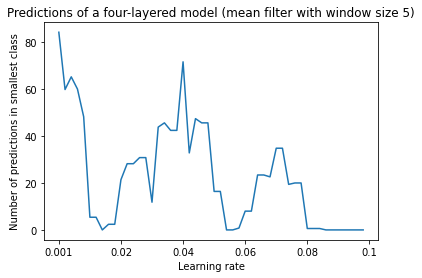

In [ ]:
plt.plot( np.convolve(models_df['min predictions nr'] / 5, np.ones(5), 'valid') )
plt.xticks([0, 10, 20, 30, 40, 50], [0.001, 0.020, 0.040, 0.060, 0.080, 0.100])
plt.xlabel('Learning rate')
plt.ylabel('Number of predictions in smallest class')
plt.title('Predictions of a four-layered model (mean filter with window size 5)');

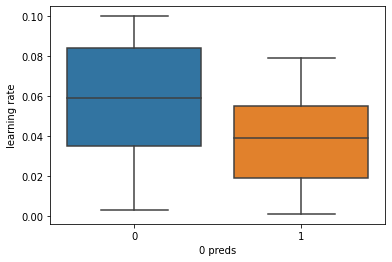

In [ ]:
#models_df.loc[models_df['min predictions nr'] != 0, '0 preds'] = 1
#models_df.loc[models_df['min predictions nr'] == 0, '0 preds'] = 0

import seaborn as sns

sns.boxplot(data=models_df, x='0 preds', y='learning rate')
plt.xlabel = ''


#Saving our model:

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# torch.save(model.state_dict(), '/content/gdrive/My Drive/weights_model.txt')

In [ ]:
models_df.columns

Index(['optimizer', 'loss function', 'model + layers', 'n epochs',
       'batch size', 'accuracy', 'min predictions nr', 'min predictions group',
       'matrix', 'Atelectasis Recall', 'Atelectasis Precision',
       'Atelectasis F1', 'Atelectasis roc', 'Effusion Recall',
       'Effusion Precision', 'Effusion F1', 'Effusion roc',
       'Infiltration Recall', 'Infiltration Precision', 'Infiltration F1',
       'Infiltration roc', 'No Finding Recall', 'No Finding Precision',
       'No Finding F1', 'No Finding roc', 'Nodule Recall', 'Nodule Precision',
       'Nodule F1', 'Nodule roc', 'Pneumothorax Recall',
       'Pneumothorax Precision', 'Pneumothorax F1', 'Pneumothorax roc',
       'mean (micro) micro avg', 'mean (micro) micro avg roc'],
      dtype='object')